In [28]:
#take boxes determined by marisol from kathleens biforcation data and calculate average environmental information for them
#want to calculate average SST, SSS, u^2+v^2, and var(u^2+v^2)
#recaluclate spd, dir from u,v after averaging in subset routine
import xarray as xr
import numpy as np
from math import pi
import datetime as dt
import os
from os.path import exists
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import *; from dateutil.relativedelta import *
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter
import sys
import geopandas as gpd

import shapefile
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib
from shapely.geometry import Polygon
import pyproj
from shapely.geometry import Point
import matplotlib.path as mpltPath
from shapely.geometry.multipolygon import MultiPolygon
import xarray as xr

import cartopy.crs as ccrs
from cartopy.examples.arrows import sample_data

sys.path.append('./subroutines/')
from shapefile_reading import explode_polygon
from shapefile_reading import get_pices_mask


In [31]:

dir_figs = 'F:/data/NASA_biophysical/pices/figures/'
dir_timeseries = 'F:/data/NASA_biophysical/timeseries_data/'
dir_shp = 'F:/data/NASA_biophysical/pices/shapefiles/LME/'
data_dir = 'F:/data/NASA_biophysical/pices/shapefiles/LME/'


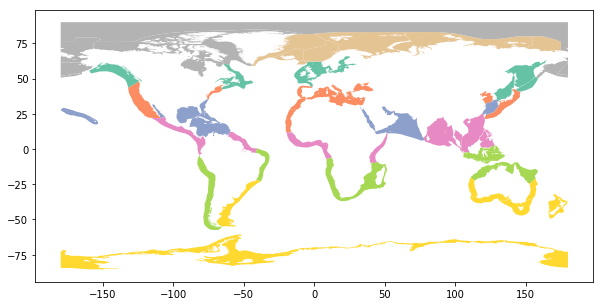

In [32]:
#process 66_LME file into individual masks and one mask with all values.

lats,lons=np.arange(-90,90,.1),np.arange(-180,180,.1)
shp_file_base = 'LME66.shp'


#create 2d grid from lats and lons
[lon2d,lat2d]=np.meshgrid(lons,lats)

#create a list of coordinates of all points within grid
points=[]
for latit in range(0,lats.size):
    for lonit in range(0,lons.size):
        point=(lon2d[latit,lonit],lat2d[latit,lonit])
        points.append(point)

#turn into np array for later
points=np.array(points)

##get the cube data - useful for later
#fld=np.squeeze(cube.data)

#create a mask array of zeros, same shape as fld, to be modified by
#the code below


df = gpd.read_file(data_dir+shp_file_base)
crs_source = ('+proj=natearth +ellps=GRS80 +unit=m +lon_0=180')
df.crs = crs_source  
df.plot(cmap='Set2', figsize=(10, 10),vmin=0,vmax=100);
#plt.legend()
plt.savefig('F:/data/NASA_biophysical/LME66.png')

indf = df.copy(deep=True)
outdf = gpd.GeoDataFrame(columns=indf.columns)
mask_all=np.zeros_like(lon2d)
init_data=0
sv_names=np.empty(67).astype('str')
for iob in range(1,67):
    mask=np.zeros_like(lon2d)

    subset = df.loc[df['OBJECTID']==iob]
    name_region = subset['LME_NAME'][iob-1].replace(" ", "_")
    num_region = subset['LME_NUMBER'][iob-1].astype('int')

    Edf2=explode_polygon(subset)

    for index,row in Edf2.iterrows():
        #print('working on polygon', index)
        mypolygon=[]
        for pt in list(row['geometry'].exterior.coords):
            #print(index,', ',pt)
            mypolygon.append(pt)
        path=mpltPath.Path(mypolygon)
        inside=path.contains_points(points)
        #find the results in the array that were inside the polygon ('True')
        #and set them to missing. First, must reshape the result of the search
        #('points') so that it matches the mask & original data
        #reshape the result to the main grid array
        inside=np.array(inside).reshape(lon2d.shape)
        i=np.where(inside == True)
        mask[i]=1
        mask_all[i]=num_region

    ds_mask_tem=xr.Dataset(data_vars={'region_mask': (('lat','lon'),mask) },coords={'lat':lats,'lon':lons})
    ds_mask_tem['region_mask'].attrs['LME_name'] = name_region
    mask_name = str(num_region)+'_mask'
    filename_out = data_dir+mask_name+'_mask.nc'
    ds_mask_tem.to_netcdf(filename_out)
    sv_names[num_region]=name_region
ds_mask=xr.Dataset(data_vars={'region_mask': (('lat','lon'),mask_all),'LME_names':(('region'),sv_names )},coords={'lat':lats,'lon':lons,'region':np.arange(1,68,1)})
filename_out = data_dir+'all_mask.nc'
ds_mask.to_netcdf(filename_out)
    

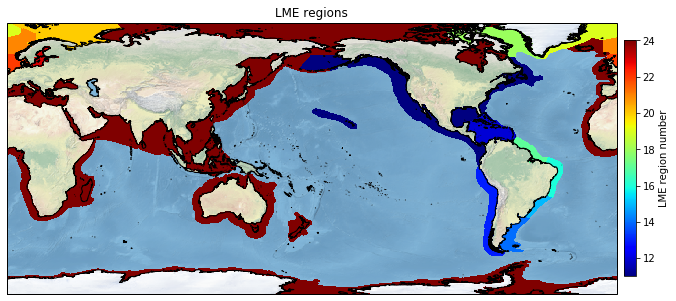

In [42]:
filename_out = data_dir+'all_mask.nc'
ds_mask=xr.open_dataset(filename_out)
ds_mask.close()
ds_mask2 = ds_mask.where(ds_mask!=0,np.nan)
import cartopy.crs as ccrs
from cartopy.examples.arrows import sample_data
plt.figure(figsize=(13,6.2))
ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=180))#, 
#                                               min_latitude=-80, max_latitude=80))
ax.background_img(name='ne_shaded', resolution='low')
#ax.background_img(name='BM', resolution='high')
ax.set_extent([1,-1,-80,80])
mm = ax.pcolormesh(ds_mask.lon,\
                   ds_mask.lat,\
                   ds_mask2.region_mask,vmin=11, vmax=24, transform=ccrs.PlateCarree(),cmap='jet' )
ax.coastlines(resolution='10m');
plt.title('LME regions')
plt.colorbar(mm,ax=ax,shrink=.7,pad=.01,label='LME region number')
plt.savefig('F:/data/NASA_biophysical/pices/figures/LME_all_regions_mask_be.png', dpi=100)


In [3]:
#process PICES file into individual masks and one mask with all values.
#some are in lat/lon and some are in coordinate reference frame so I had to add a check for that

dir_shp = 'F:/data/NASA_biophysical/pices/shapefiles/pices/'
data_dir = 'F:/data/NASA_biophysical/pices/shapefiles/pices/'
data_fig = 'F:/data/NASA_biophysical/pices/figures/'

lats,lons=np.arange(-90,90,.1),np.arange(-180,180,.1)
#shp_file_base = 'PICES_NPESR_Region_12.shp'


#create 2d grid from lats and lons
[lon2d,lat2d]=np.meshgrid(lons,lats)

#create a list of coordinates of all points within grid
points=[]
for latit in range(0,lats.size):
    for lonit in range(0,lons.size):
        point=(lon2d[latit,lonit],lat2d[latit,lonit])
        points.append(point)

#turn into np array for later
points=np.array(points)

##get the cube data - useful for later
#fld=np.squeeze(cube.data)

#create a mask array of zeros, same shape as fld, to be modified by
#the code below

#there are some masks that wrap 180 which causes problems for the 'find inside'
#for these there is a cheap below, instead of +lon_0=180
#I put in +lon_0=0, create the mask then shift it to the-180,180 mask and save
mask_all=np.zeros_like(lon2d)

dir_data='F:/data/NASA_biophysical/pices/shapefiles/pices/'
for root, dirs, files in os.walk(dir_data, topdown=False):
    if root[len(dir_data):len(dir_data)+1]=='.':
        continue
    for name in files:
        if not name.endswith('.shp'):
            continue
        filename=os.path.join(root, name)
        print(name[:-4])
        name_region = name[:-4]
        num_region = int(name[-6:-4])
#        if (num_region<12) | (num_region>12):
#            continue
#        if ((num_region<13)|(num_region>15)):
#            continue
        df = gpd.read_file(filename)
        if ((num_region == 13) | (num_region==14) | (num_region==23) | (num_region==24) | (num_region==15)):
            crs_source = ('+proj=natearth +ellps=GRS80 +unit=m +lon_0=0')
            iwrap=1
        else:
            crs_source = ('+proj=natearth +ellps=GRS80 +unit=m +lon_0=180')
            iwrap=0
        df.crs = crs_source  
#check if in ITM or geocoordinates
        Edf2=explode_polygon(df)
        for index,row in Edf2.iterrows():
            #print('working on polygon', index)
            mypolygon=[]
            for pt in list(row['geometry'].exterior.coords):
                #print(index,', ',pt)
                mypolygon.append(pt)
        if (pt[0]>-180) & (pt[0]<180):
            df2 = df.copy(deep=True)
            print('nope: dont change coordinates')
        else:
            df2 = df.to_crs(epsg=4326) 
            print('yup, change coordinates')  
        
   #     df2.plot(cmap='Set2', figsize=(10, 10),vmin=0,vmax=100);
        #plt.legend()
   #     plt.savefig(data_fig + name_region+'.png')

        indf = df2.copy(deep=True)
        outdf = gpd.GeoDataFrame(columns=indf.columns)
        init_data=0
        mask=np.zeros_like(lon2d)

#        subset = df.loc[df['OBJECTID']==iob]

        Edf2=explode_polygon(df2)

        for index,row in Edf2.iterrows():
            #print('working on polygon', index)
            mypolygon=[]
            for pt in list(row['geometry'].exterior.coords):
                mypolygon.append(pt)
            path=mpltPath.Path(mypolygon)
            inside=path.contains_points(points)
            #find the results in the array that were inside the polygon ('True')
            #and set them to missing. First, must reshape the result of the search
            #('points') so that it matches the mask & original data
            #reshape the result to the main grid array
            inside=np.array(inside).reshape(lon2d.shape)
            i=np.where(inside == True)
            mask[i]=1
#            mask_all[i]=num_region
        if (iwrap==1):
            mask2=np.zeros(mask.shape)
            mask2[:,1:1800]=mask[:,1801:3600]#,mask[:,1:1800]]
            mask2[:,1800:3600]=mask[:,1:1801]
        else:
            mask2=mask
        if (num_region==15):
            mask2=mask
            
        mask_all= np.where(mask2==1,num_region,mask_all)
    ds_mask_tem=xr.Dataset(data_vars={'region_mask': (('lat','lon'),mask2) },coords={'lat':lats,'lon':lons})
    ds_masked = ds_mask_tem.where(ds_mask_tem['region_mask'] != 0)  
    min_lat,max_lat = lat2d[np.isfinite(ds_masked.region_mask)].min(),lat2d[np.isfinite(ds_masked.region_mask)].max()
    min_lon,max_lon = lon2d[np.isfinite(ds_masked.region_mask)].min(),lon2d[np.isfinite(ds_masked.region_mask)].max()
    ds_mask_tem['region_mask'].attrs['PICES_name'] = name_region
    ds_mask_tem['region_mask'].attrs['min_lon'] = min_lon
    ds_mask_tem['region_mask'].attrs['max_lon'] = max_lon
    ds_mask_tem['region_mask'].attrs['min_lat'] = min_lat
    ds_mask_tem['region_mask'].attrs['max_lat'] = max_lat
    mask_name = str(num_region)
    filename_out = data_dir+mask_name+'_mask.nc'
    ds_mask_tem.to_netcdf(filename_out)
ds_mask_tem=xr.Dataset(data_vars={'region_mask': (('lat','lon'),mask_all) },coords={'lat':lats,'lon':lons})
ds_masked = ds_mask_tem.where(ds_mask_tem['region_mask'] != 0)  
min_lat,max_lat = lat2d[np.isfinite(ds_masked.region_mask)].min(),lat2d[np.isfinite(ds_masked.region_mask)].max()
min_lon,max_lon = lon2d[np.isfinite(ds_masked.region_mask)].min(),lon2d[np.isfinite(ds_masked.region_mask)].max()
ds_mask_tem['region_mask'].attrs['PICES_name'] = 'all'
ds_mask_tem['region_mask'].attrs['min_lon'] = min_lon
ds_mask_tem['region_mask'].attrs['max_lon'] = max_lon
ds_mask_tem['region_mask'].attrs['min_lat'] = min_lat
ds_mask_tem['region_mask'].attrs['max_lat'] = max_lat
mask_name = 'PICES_all'
filename_out = data_dir+mask_name+'_mask.nc'
ds_mask_tem.to_netcdf(filename_out)
            
    

PICES_NPESR_Region_11
yup, change coordinates
PICES_NPESR_Region_12
nope: dont change coordinates
PICES_NPESR_Region_13
yup, change coordinates
PICES_NPESR_Region_14
yup, change coordinates
PICES_NPESR_Region_15
nope: dont change coordinates
PICES_NPESR_Region_16
yup, change coordinates
PICES_NPESR_Region_17
yup, change coordinates
PICES_NPESR_Region_18
yup, change coordinates
PICES_NPESR_Region_19
yup, change coordinates
PICES_NPESR_Region_20
yup, change coordinates
PICES_NPESR_Region_21
yup, change coordinates
PICES_NPESR_Region_22
yup, change coordinates
PICES_NPESR_Region_23
yup, change coordinates
PICES_NPESR_Region_24
yup, change coordinates


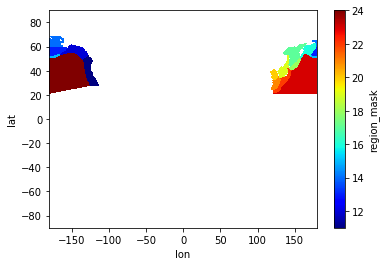

In [20]:
ds_mask_tem2 = ds_mask_tem.where(ds_mask_tem>0,np.nan)
ds_mask_tem2.region_mask.plot(cmap='jet',vmin=11,vmax=24)

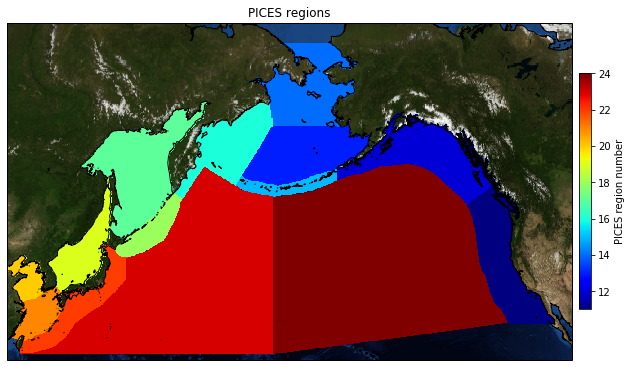

In [24]:
import cartopy.crs as ccrs
from cartopy.examples.arrows import sample_data
plt.figure(figsize=(13,6.2))
ax = plt.subplot(111, projection=ccrs.Mercator(central_longitude=180, 
                                               min_latitude=20, max_latitude=70))
#ax.background_img(name='ne_shaded', resolution='low')
ax.background_img(name='BM', resolution='high')
ax.set_extent([118,-110,20,70])
mm = ax.pcolormesh(ds_mask_tem2.lon,\
                   ds_mask_tem2.lat,\
                   ds_mask_tem2.region_mask,vmin=11, vmax=24, transform=ccrs.PlateCarree(),cmap='jet' )
ax.coastlines(resolution='10m');
plt.title('PICES regions')
plt.colorbar(mm,ax=ax,shrink=.7,pad=.01,label='PICES region number')
plt.savefig('F:/data/NASA_biophysical/pices/figures/PICES_all_regions_mask_be.png', dpi=100)


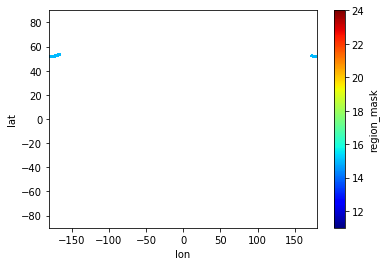

In [27]:
#example on how to mask data for just one region
filename = 'F:/data/NASA_biophysical/pices/shapefiles/pices/PICES_all_mask.nc'
ds_pices = xr.open_dataset(filename)
ds_pices.close()
ds_mask = ds_pices.where(ds_pices==15,np.nan)
ds_mask.region_mask.plot(cmap='jet',vmin=11,vmax=24)